In [1]:
"""
This notebook implements a fraud detection system with the following steps:

1. Data preparation:
    - Loads engineered transaction data from 'engineered_transactions.csv'
    - Uses features like transaction amount, customer history, and fraud patterns

2. Model training and evaluation:
    - Trains multiple models (Random Forest, XGBoost, Logistic Regression, LightGBM)
    - Evaluates using metrics: AUC-ROC, F1-score, and Recall
    - Creates performance comparison visualizations

3. Model deployment:
    - Saves the best performing model to disk

4. Model interpretation:
    - Generates feature importance plots using XGBoost
    - Creates SHAP (SHapley Additive exPlanations) values for model interpretability

Key features tracked:
- Transaction amounts
- High amount flags
- Customer transaction history (7 days)
- Terminal fraud history (28 days)
- Customer average amounts
- Amount to average ratios
"""

"\nThis notebook implements a fraud detection system with the following steps:\n\n1. Data preparation:\n    - Loads engineered transaction data from 'engineered_transactions.csv'\n    - Uses features like transaction amount, customer history, and fraud patterns\n\n2. Model training and evaluation:\n    - Trains multiple models (Random Forest, XGBoost, Logistic Regression, LightGBM)\n    - Evaluates using metrics: AUC-ROC, F1-score, and Recall\n    - Creates performance comparison visualizations\n\n3. Model deployment:\n    - Saves the best performing model to disk\n\n4. Model interpretation:\n    - Generates feature importance plots using XGBoost\n    - Creates SHAP (SHapley Additive exPlanations) values for model interpretability\n\nKey features tracked:\n- Transaction amounts\n- High amount flags\n- Customer transaction history (7 days)\n- Terminal fraud history (28 days)\n- Customer average amounts\n- Amount to average ratios\n"

In [2]:
%pip install xgboost lightgbm


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\ADMIN\OneDrive\Desktop\internship\fraud_detection\env\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


In [4]:
df = pd.read_csv("../outputs/engineered_transactions.csv")
df.fillna(0, inplace=True)

features = [
    'TX_AMOUNT',
    'IS_HIGH_AMOUNT',
    'CUSTOMER_TX_COUNT_7D',
    'TERMINAL_FRAUD_COUNT_28D',
    'CUSTOMER_AVG_AMOUNT_7D',
    'AMOUNT_TO_AVG_RATIO'
]

X = df[features]
y = df['TX_FRAUD']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [ ]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "LightGBM": LGBMClassifier(class_weight='balanced')
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "AUC": auc,
        "F1": f1,
        "Recall": recall
    })
    
    print(f"\n🧪 {name} Results")
    print(classification_report(y_test, y_pred))



🧪 Random Forest Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    521843
           1       0.70      0.56      0.62      4404

    accuracy                           0.99    526247
   macro avg       0.85      0.78      0.81    526247
weighted avg       0.99      0.99      0.99    526247



c:\Users\ADMIN\OneDrive\Desktop\internship\fraud_detection\env\lib\site-packages\xgboost\core.py:158: UserWarning: [22:22:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🧪 XGBoost Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    521843
           1       0.68      0.67      0.67      4404

    accuracy                           0.99    526247
   macro avg       0.84      0.84      0.84    526247
weighted avg       0.99      0.99      0.99    526247




📋 Model Comparison:
                 Model       AUC        F1    Recall
1              XGBoost  0.995657  0.674323  0.673252
3             LightGBM  0.995574  0.383638  0.956176
2  Logistic Regression  0.992092  0.494555  0.933243
0        Random Forest  0.970252  0.621530  0.561762




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



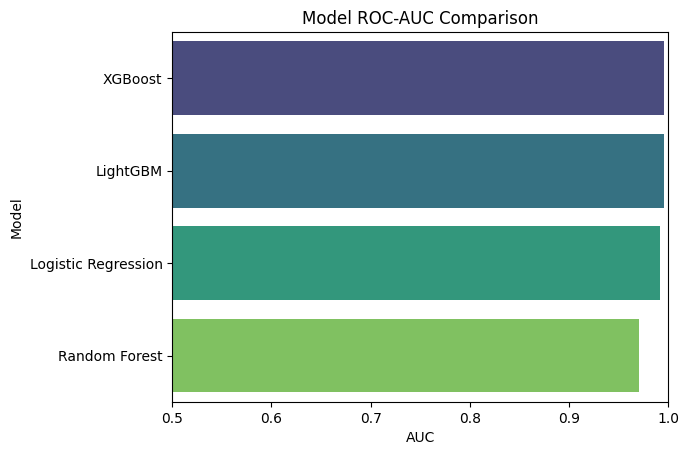

In [ ]:
results_df = pd.DataFrame(results).sort_values(by="AUC", ascending=False)
print("\n📋 Model Comparison:")
print(results_df)

sns.barplot(x="AUC", y="Model", data=results_df, palette="viridis")
plt.title("Model ROC-AUC Comparison")
plt.xlim(0.5, 1.0)
plt.show()


In [ ]:
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

joblib.dump(best_model, f"../models/{best_model_name.lower().replace(' ', '_')}_model.pkl")
print(f"✅ Best model ({best_model_name}) saved to models/{best_model_name.lower().replace(' ', '_')}_model.pkl")


✅ Best model (XGBoost) saved to models/xgboost_model.pkl


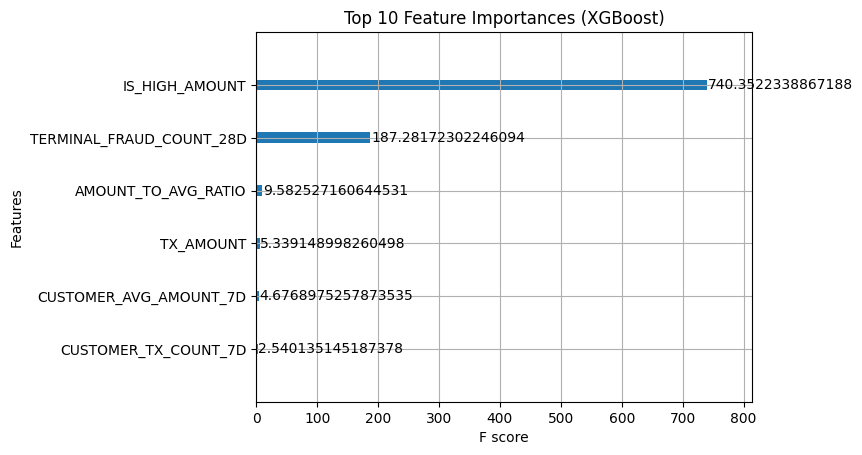

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Reload model if needed
import joblib
xgb = joblib.load("../models/xgboost_model.pkl")

plot_importance(xgb, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()


In [ ]:
%pip install shap


Note: you may need to restart the kernel to use updated packages.


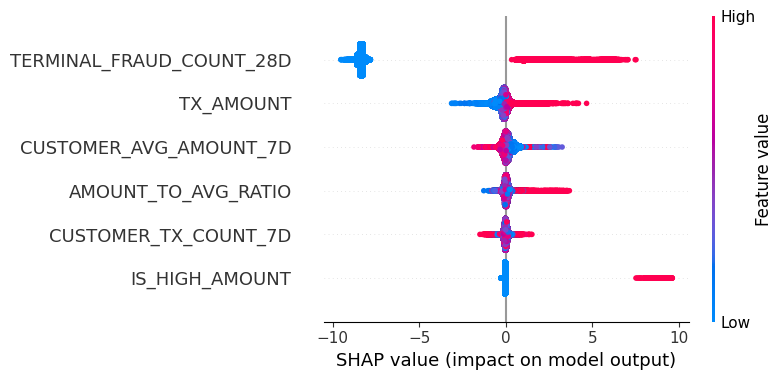

In [ ]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


In [ ]:
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
